In [1]:
%load_ext autoreload
%autoreload 2

### imports and utilities

In [2]:
!pip install nltk scikit-learn matplotlib scipy

In [3]:
import nltk
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\christian\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\christian\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\christian\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [4]:
from collections import Counter
from utils import *

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm
from scipy.special import softmax
from scipy.stats import norm
from scipy.stats import entropy as calculate_entropy


from sklearn.decomposition import PCA
from sklearn.preprocessing import normalize
from sklearn.datasets import fetch_20newsgroups
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

### load dataset

In [5]:
dataset = "newsgroup"

# total number of samples needed
randomize = False

# retrieve dataset
categories = ['rec.autos', 'talk.politics.mideast', 'alt.atheism', 'sci.space']

docs = fetch_20newsgroups(subset='train', shuffle=randomize, remove=('headers', 'footers', 'quotes'), categories=categories)
docs, old_labels, classes = docs.data, docs.target, docs.target_names

In [6]:
# dataset = "bbc"

# data = pd.read_csv('bbcsport.csv')

# docs = data["text"].to_list()
# old_labels = data["topic"].to_list()
# categories = classes = np.unique(data["topic"]).tolist()

### clean dataset

In [7]:
datasize = 50
min_document_length = 128
max_document_length = 512


index = -1
train_docs, labels, label_indices = [], [], []

sizes = [0]*len(categories)

with tqdm(total=len(categories)*datasize) as pbar:
    while sum(sizes) != len(categories)*datasize:
        index += 1
        
        if dataset == "bbc":
            size_index = categories.index(old_labels[index])
            
        else:
            size_index = categories.index(classes[old_labels[index]])
        
        if sizes[size_index] == datasize:
            continue
        
        doc = docs[index]
        status, doc, word_count = clean_doc(doc, True)
        
        if not status:
            continue
            
        if min_document_length is not None and len(doc) < min_document_length:
            continue
            
        if max_document_length is not None and len(doc) > max_document_length:
            continue
        
        label_indices.append(size_index)
        labels.append(categories[size_index])
        train_docs.append(doc)
        sizes[size_index] += 1
        pbar.update(1)

labels = np.array(labels)
label_indices = np.array(label_indices)

In [8]:
index = 0
print(f"Topic: {labels[index]}\n{'='*50}\n{train_docs[index]}")

Topic: alt.atheism
i think that domestication will change behavior to a large degree domesticate animal exhibit behavior not found in the wild i don t think that they can be view a good representative of the wild animal kingdom since they have be breed for thousand of year to produce certain behavior etc


In [9]:
print(sizes)
assert min(sizes) == max(sizes) == datasize

[50, 50, 50, 50]


In [10]:
print(f"there are {len(train_docs)} docs")

there are 200 docs


### Initialize Vectorizer

In [11]:
# initialize the count vectorizer
vectorizer = CountVectorizer()

# fit it to dataset
vectorizer.fit(train_docs)

vocabulary = vectorizer.get_feature_names()
print("word_count is", len(vocabulary))

word_count is 2705


### Prepare Datatset

In [12]:
# create doc count vectors
train_doc_vectors = vectorizer.transform(train_docs).toarray()

total_num_of_documents = len(train_doc_vectors)
print(f"{total_num_of_documents} train_docs")

200 train_docs


### Word-Word Ratio

In [13]:
# reduce freq in doc to bin value of 1 or 0
word_freq_in_doc = pd.DataFrame(train_doc_vectors, columns=vocabulary)
word_word_co = pd.DataFrame(data=0.0, columns=vocabulary, index=vocabulary)

word_doc_frequency = (word_freq_in_doc > 0).astype(int)
word_doc_frequency_norm = (word_freq_in_doc.T / word_freq_in_doc.sum(1)).T

probability = word_doc_frequency.sum(0) / len(train_doc_vectors)

for word in tqdm(vocabulary):
    pxy = word_doc_frequency[word_doc_frequency[word] == 1].sum(0) / total_num_of_documents
#     word_word_co[word] = np.log1p(pxy / (probability[word] * probability))
#     word_word_co[word] = pxy / (probability[word] * probability)
    word_word_co[word] = pxy / probability[word]

word_word_co -= word_word_co.min().min()
word_word_co /= word_word_co.max().max()
print(f"word_word_co has shape {word_word_co.shape}")


word_word_co has shape (2705, 2705)


In [14]:
word_word_co.head()

,000,04110,0988,0b1fatransfer,10,1000,11,124mph,12cyl,14,...,young,your,yours,yourself,zeitgeist,zero,zion,zionist,zu,zuma
000,1.00,0.0,0.0,0.0,0.25,0.0,0.0,0.0,0.0,0.0,...,0.0,0.046512,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
04110,0.00,1.0,1.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0988,0.00,1.0,1.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0b1fatransfer,0.00,0.0,0.0,1.0,0.00,0.0,0.0,0.0,0.0,0.0,...,0.0,0.023256,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10,0.25,0.0,0.0,0.0,1.00,0.0,0.0,0.0,0.0,0.0,...,0.0,0.023256,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


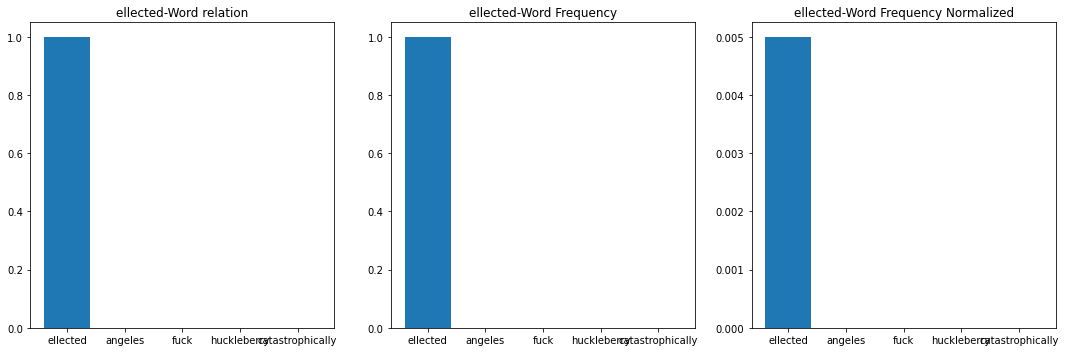

In [15]:
# word = "car"
# words = ["the", "driver", "usually", "software", "window"]

words = np.array(vocabulary)[np.random.randint(len(vocabulary), size=5)]
word = words[0]

fig = plt.figure(figsize=(15,5), tight_layout=True)
ax11 = fig.add_subplot(131)
ax12 = fig.add_subplot(132)
ax13 = fig.add_subplot(133)

ax11.set_title(f"{word}-Word relation")
ax11.bar(words, word_word_co.loc[word][words])

pxy = word_doc_frequency[word_doc_frequency[word] == 1].sum(0)

ax12.set_title(f"{word}-Word Frequency")
ax12.bar(words, pxy[words])

pxy /= total_num_of_documents

ax13.set_title(f"{word}-Word Frequency Normalized")
ax13.bar(words, pxy[words])

plt.show()

## reduce word dimensions

In [35]:
word_weight = word_word_co.mean(0).sort_values(ascending=False)
best_words = word_weight.index

for word_index in tqdm(range(1, len(word_weight))):
    selected_best_words = best_words[:word_index]
    if not word_doc_frequency_norm[selected_best_words].mean(1).eq(0).any().any():
        break

selected_best_words = np.array(selected_best_words)
word_word_co = word_word_co[selected_best_words]
word_doc_frequency_norm = word_doc_frequency_norm[selected_best_words]

print(f"using only {len(selected_best_words)} best word(s)")
print(selected_best_words[:10])


using only 1407 best word(s)
['setup' 'brake' 'television' 'taurus' 'driven' 'boil' 'sho' 'drum' 'inch'
 'pffffftttttt']


In [36]:
word_doc_frequency_norm[selected_best_words].mean(1).eq(0).any().any()

False

In [37]:
word_doc_frequency_norm[selected_best_words].mean(1).sort_values(ascending=True).head(3)

7      0.000026
20     0.000027
139    0.000032
dtype: float64

In [38]:
index = 7
print(f"Topic: {labels[index]}\n{'='*50}\n{train_docs[index]}")

Topic: talk.politics.mideast
maybe the missile didn t hit directly such that his body get desintegrated of course destroy 10 house to kill someone be not a surgical operation or be it


### Setup Doc Word Distr

In [39]:
number_of_iterations = 1
doc_word_distr = pd.DataFrame(data=0.0, columns=selected_best_words, index=range(total_num_of_documents))

total_iterations = number_of_iterations * total_num_of_documents

with tqdm(total=total_iterations) as pbar:
    for n_iter in range(number_of_iterations):
        for doc_index in (range(total_num_of_documents)):
            
            words = selected_best_words[word_doc_frequency_norm.loc[doc_index] > 0]
            doc_word_distr.loc[doc_index] = (word_doc_frequency_norm.loc[doc_index] * word_word_co.loc[words]).mean()
            pbar.update(1)
            
        print(f"overall probability sum in docs {doc_word_distr.sum().sum()}")

overall probability sum in docs 31.3957690459974



In [40]:
print(doc_word_distr.sum().sum())

31.3957690459974


In [41]:
doc_word_distr.head()

,setup,brake,television,taurus,driven,boil,sho,drum,inch,pffffftttttt,...,minute,cut,friend,day,can,at,this,true,much,for
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.007359,0.0,0.000000,0.0,0.0,0.007246
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.005357,0.0,0.001635,0.0,0.0,0.000000
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.001049,0.0,0.001875,0.0,0.0,0.000000
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000


In [42]:
doc_index = 
word_doc_frequency_norm.iloc[doc_index].sort_values(ascending=False).head(5)

IndexError: single positional indexer is out-of-bounds

In [ ]:
doc_word_distr.loc[doc_index].sort_values(ascending=False).head(5)

In [ ]:
print(f"Topic: {labels[doc_index]}\n{'='*50}\n{train_docs[doc_index]}")

### Define Latent partitions

In [ ]:
reduction = None
# reduction = "pca"
# reduction = "normal"

if reduction is None:
    columns = doc_word_distr.columns
    param_values = doc_word_distr.values

if reduction == "pca":
    num_of_components = 4
    columns = list(range(num_of_components))
    
    pca = PCA(n_components=num_of_components, whiten=False)
    param_values = pca.fit_transform(doc_word_distr)

if reduction == "normal":
    columns = ["mean", "std"]
    column_values = [doc_word_distr.sum(1), doc_word_distr.mean(1)]
    param_values = np.array(column_values).T
    
distr_params = pd.DataFrame(data=param_values, columns=columns, index=list(range(len(doc_word_distr))))
print(f"distr_params has shape {distr_params.shape}")

In [ ]:
distr_params.head()

### Using Kmeans MiniBatch

In [ ]:
num_of_topics = 4

In [ ]:
kmeans_model = KMeans(n_clusters=num_of_topics, random_state=0).fit(distr_params)

In [ ]:
dist = kmeans_model.transform(distr_params)
predicted_labels = kmeans_model.predict(distr_params)
wtf = gaussian(normalize(dist, norm="l1", axis=1))

print(f"dist has shape {dist.shape}, predicted_labels has shape {predicted_labels.shape}")

In [ ]:
Counter(predicted_labels)

In [ ]:
fig = plt.figure(figsize=(15,5), tight_layout=True)
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

ax1.set_title("Documents Space")
ax1.scatter(param_values[:, 0], param_values[:,1], c = label_indices)
ax1.set_xlabel(columns[0])
ax1.set_xlabel(columns[1])

ax2.set_title("Kmeans Documents Space")
ax2.scatter(param_values[:, 0], param_values[:,1], c = predicted_labels)
ax2.set_xlabel(columns[0])
ax2.set_xlabel(columns[1])

plt.show()

In [ ]:
def get_topwords(topic):
    indices = np.where(predicted_labels == topic)[0]
    print(doc_word_distr.iloc[indices].mean(0).sort_values(ascending=False).head(10))

def get_topwords2(topic):
    indices = np.where(predicted_labels == topic)[0]
    print((doc_word_distr.T * wtf[:, topic]).T.iloc[indices].mean(0).sort_values(ascending=False).head(10))

def get_topwords2(topic):
    indices = np.where(predicted_labels == topic)[0]
    xv = (doc_word_distr.T * wtf[:, topic]).T.iloc[indices]
    xvc = (xv > 0).sum(0)
    print((xv.sum(0) * calculate_trust_ratio(xvc) / xvc).sort_values(ascending=False).head(10))

def get_top2(topic):
    indices = dist[:, topic].argsort()
    print(labels[indices[:10]])
    get_topwords(topic)
    
def get_top(topic):
    indices = np.where(predicted_labels == topic)[0]
    count = Counter()
    for index in indices:
        count[labels[index]] += wtf[index, topic]
        
    print(Counter(labels[indices]))
    get_topwords(topic)

In [ ]:
get_top(0)

In [ ]:
get_top(1)

In [ ]:
get_top(2)

In [ ]:
get_top(3)

### LDA